<a href="https://colab.research.google.com/github/leminhviett/Digit-Recognizer/blob/master/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# 1. Prepare Data

In [3]:
train = pd.read_csv('/content/drive/My Drive/data/digit-recognizer/train.csv')
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
X_numpy = train.loc[:, train.columns != 'label'].values / 255
y_numpy = train.loc[:, 'label'].values
X_train, X_val, y_train, y_val = train_test_split(X_numpy, y_numpy, test_size = 0.1, random_state = 42)
print("X_train: {}. y_train {}".format(X_train.shape, y_train.shape))
print("X_val: {}. y_val {}".format(X_val.shape, y_val.shape))

X_train: (37800, 784). y_train (37800,)
X_val: (4200, 784). y_val (4200,)


In [0]:
X_train = torch.from_numpy(X_train).type(torch.LongTensor)
X_val = torch.from_numpy(X_val).type(torch.LongTensor)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)

train_loader = DataLoader(train, batch_size=100, shuffle=False)
val_loader = DataLoader(val, shuffle=False)

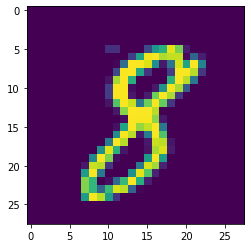

In [6]:
plt.imshow(X_numpy[20].reshape(28,28))

# 2.Model

In [0]:
class ANNModel(nn.Module):
  def __init__(self, inp_dim, out_dim, hidden_dim):
    super().__init__()
    self.lin1 = nn.Linear(inp_dim, hidden_dim)
    self.act1 = nn.ReLU()

    self.lin2 = nn.Linear(hidden_dim, hidden_dim)
    self.act2 = nn.Tanh()

    self.lin3 = nn.Linear(hidden_dim, hidden_dim)
    self.act3 = nn.ELU()

    self.lin4 = nn.Linear(hidden_dim, out_dim)

  def forward(self, input):
    out = self.lin1(input)
    out = self.act1(out)
    out = self.lin2(out)
    out = self.act2(out)
    out = self.lin3(out)
    out = self.act3(out)
    out = self.lin4(out)

    return out

First, we train on our train set; then validate on validation set for each 500-iteration to make sure our model is learning !

In [8]:
model = ANNModel(28*28, 10, 200)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = nn.CrossEntropyLoss()
iter_count = 0
for epoch in range(30):
  for i, (imgs, labels) in enumerate(train_loader):

    train = imgs.view(-1, 28*28).type(torch.FloatTensor)
    labels = labels

    optimizer.zero_grad()
    predicted = model(train)
    loss_train = loss_fn(predicted, labels)
    loss_train.backward()
    optimizer.step()

    if(iter_count %500 == 0):
      for (img, labels) in val_loader:
        with torch.no_grad():
          loss_val = loss_fn(model(img.view(-1, 28*28).type(torch.FloatTensor)), labels)
      print('Iteration: {}  Loss_train: {} Loss_val: {}'.format(iter_count, loss_train, loss_val))

    iter_count += 1

    

Iteration: 0  Loss_train: 2.308821201324463 Loss_val: 2.3193860054016113
Iteration: 500  Loss_train: 2.287684679031372 Loss_val: 2.4015281200408936
Iteration: 1000  Loss_train: 2.151944637298584 Loss_val: 2.332181930541992
Iteration: 1500  Loss_train: 1.9700055122375488 Loss_val: 2.184962034225464
Iteration: 2000  Loss_train: 1.8591629266738892 Loss_val: 2.00014328956604
Iteration: 2500  Loss_train: 1.7325456142425537 Loss_val: 2.0880141258239746
Iteration: 3000  Loss_train: 1.5875781774520874 Loss_val: 2.205444574356079
Iteration: 3500  Loss_train: 1.4909271001815796 Loss_val: 2.0721871852874756
Iteration: 4000  Loss_train: 1.6377276182174683 Loss_val: 1.807476282119751
Iteration: 4500  Loss_train: 1.7005376815795898 Loss_val: 2.057535171508789
Iteration: 5000  Loss_train: 1.6754440069198608 Loss_val: 2.172574520111084
Iteration: 5500  Loss_train: 1.4475878477096558 Loss_val: 1.9462988376617432
Iteration: 6000  Loss_train: 1.4795068502426147 Loss_val: 1.5690542459487915
Iteration: 650

As we can see, the validation loss is slightly higher than that of training set.

Then, we continue training on the whole data set.

In [9]:
X_train_all = torch.from_numpy(X_numpy).type(torch.LongTensor)
y_train_all = torch.from_numpy(y_numpy)
train_all = TensorDataset(X_train, y_train)
train_loader_all = DataLoader(train_all, batch_size=100, shuffle=False)

optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.01, lr_decay=1e-3)

for epoch in range(30):
  for i, (imgs, labels) in enumerate(train_loader_all):

    train = imgs.view(-1, 28*28).type(torch.FloatTensor)
    labels = labels

    optimizer.zero_grad()
    predicted = model(train)
    loss_train = loss_fn(predicted, labels)
    loss_train.backward()
    optimizer.step()

    if(iter_count %500 == 0):
      print('Iteration: {}  Loss_train: {}'.format(iter_count, loss_train))

    iter_count += 1

Iteration: 11500  Loss_train: 1.6792291402816772
Iteration: 12000  Loss_train: 1.4494261741638184
Iteration: 12500  Loss_train: 1.299837350845337
Iteration: 13000  Loss_train: 1.2919193506240845
Iteration: 13500  Loss_train: 1.4794502258300781
Iteration: 14000  Loss_train: 1.3686453104019165
Iteration: 14500  Loss_train: 1.4274919033050537
Iteration: 15000  Loss_train: 1.4633593559265137
Iteration: 15500  Loss_train: 1.5104366540908813
Iteration: 16000  Loss_train: 1.441560983657837
Iteration: 16500  Loss_train: 1.3713552951812744
Iteration: 17000  Loss_train: 1.5692270994186401
Iteration: 17500  Loss_train: 1.4742474555969238
Iteration: 18000  Loss_train: 1.4933106899261475
Iteration: 18500  Loss_train: 1.416594386100769
Iteration: 19000  Loss_train: 1.420253038406372
Iteration: 19500  Loss_train: 1.2872108221054077
Iteration: 20000  Loss_train: 1.3462196588516235
Iteration: 20500  Loss_train: 1.4143182039260864
Iteration: 21000  Loss_train: 1.450474500656128
Iteration: 21500  Loss_tr

In [11]:
model

ANNModel(
  (lin1): Linear(in_features=784, out_features=200, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=200, out_features=200, bias=True)
  (act2): Tanh()
  (lin3): Linear(in_features=200, out_features=200, bias=True)
  (act3): ELU(alpha=1.0)
  (lin4): Linear(in_features=200, out_features=10, bias=True)
)

**Our model is ready to use !**

In [24]:
test = pd.read_csv('/content/drive/My Drive/data/digit-recognizer/test.csv')

test_tensor = torch.tensor(test.values).type(torch.FloatTensor)
predicted = model(test_tensor.view(-1, 28*28)).data
predicted = torch.max(predicted, 1)[1]
print(predicted)

tensor([2, 0, 9,  ..., 3, 9, 2])


In [32]:
import pandas
csv_file = pandas.DataFrame({'ImageId':[i for i in range(1, 28001)], 'Label':predicted})
csv_file.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,2


In [0]:
csv_file.to_csv('/content/drive/My Drive/data/digit-recognizer/submission.csv', index = None)